<a href="https://colab.research.google.com/github/Saeed-Akbari/CS5783-MachineLearning/blob/main/Assignment3/problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required packages.

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from  torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
#from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
#from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split

from torchsummary import summary
# from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
# This cell is to handle resources, e.g., CPU and GPU.

#function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# a function that can move data and model to a chosen device.    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


#Finally, we define a DeviceDataLoader class to wrap our existing data loaders
#and move data to the selected device, as a batches are accessed.
#Interestingly, we don't need to extend an existing class to create a PyTorch
#dataloader. 
#All we need is an __iter__ method to retrieve batches of data, and
#an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# This function plots accuracy

def plot_scores(history):
#     scores = [x['val_score'] for x in history]
    acc = [x['val_acc'] for x in history]
    plt.plot(acc, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc vs. No. of epochs');

In [ ]:
# This function plots losses

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
# This decorator deactivates the autograd engine (tracking of gradients) to
# reduce memory usage and boost computational speed for evaluation phase.
@torch.no_grad()
def evaluate(model, val_loader):
    # batchnorm or dropout layers will work in eval mode instead of training mode
    model.eval()
    # Calculate loss on data coming from validation set
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# fit function is for training step
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    # scheduler = OneCycleLR(optimizer, lr, epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            # Calculate loss on data coming from training set
            loss = model.training_step(batch)
            # keep all losses on different batches of training data
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # scheduler.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        # model.epoch_end(epoch, result,scheduler.get_lr())
        model.epoch_end(epoch, result,lr)
        history.append(result)
    return history

In [ ]:
# downloading MNIST dataset (both training and test sets)

torch.manual_seed(1)

dataset = MNIST(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = MNIST(root='data/', download=True, train=False, transform=ToTensor())

In [ ]:
# calculate accuracy by counting the number of true predictions and dividing it
# to the whole number of predictions.
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# This class is parent for the next class "MnistModel".
# This class inherits charactristics from "torch.nn.Module" class.

class MnistModelBase(torch.nn.Module):
    # Calculate loss on training set
    def training_step(self, batch):
        images, targets = batch   # extracting features and labels
        out = self(images)        # calculate the output or yhat
        loss = F.cross_entropy(out, targets)  # calculate loss function
        return loss     # return loss
    
    # Calculate loss on validation set
    def validation_step(self, batch):
        images, targets = batch    # extracting features and labels
        out = self(images)        # calculate the output or yhat
        loss = F.cross_entropy(out, targets)  # Calculate loss
        # calculate the accuracy based on the function I already defined in the above cells
        acc = accuracy(out, targets)
        # return a dictionary including loss and accuracy of validation set
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    # show some metrics during training
    def epoch_end(self, epoch, result,LR):
        print("Epoch [{}] - LR [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,LR,result['train_loss'], result['val_loss'], result['val_acc']))

**Part 1.** A regular CNN where the number of filters in each layer increases as the depth of the network grows i.e., the L th layer will have more filters than the (L-1) th layer.

I change batch size, learning rate, and optimizer to compare their effects of accuracy.

In [ ]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 20     # number of epochs
lr = 0.001      # learning rate
opt_func = torch.optim.Adam     # optimizer

In [ ]:
# This class inherits from "MnistModelBase" class.
# Layers of the CNN is defined here.

class MnistModel1(MnistModelBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self):
        super().__init__()

        # size: (channel-in, channel-out, kernel size)
        self.conv1 = torch.nn.Conv2d(1, 4, 3, padding='same')
        self.conv2 = torch.nn.Conv2d(4, 8, 3, padding='same')
        self.conv3 = torch.nn.Conv2d(8, 12, 3, padding='same')
        self.conv4 = torch.nn.Conv2d(12, 16, 3, padding='same')
        self.conv5 = torch.nn.Conv2d(16, 20, 3, padding='same')
        self.conv6 = torch.nn.Conv2d(20, 24, 3, padding='same')
        self.conv7 = torch.nn.Conv2d(24, 26, 3, padding='same')
        self.conv8 = torch.nn.Conv2d(26, 28, 3, padding='same')
        self.conv9 = torch.nn.Conv2d(28, 30, 3, padding='same')
        self.conv10 = torch.nn.Conv2d(30, 32, 3)

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(5408, 100)
        self.fc2 = torch.nn.Linear(100, 10)  # 10 classes

    def forward(self, xb):

        # CNN
        x = self.relu(self.conv1(xb))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.pool(x)

        # MLP
        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# size of training set is the total size minus the size of val set
train_size = len(dataset) - val_size

# split dataset between two training and validation sets.
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [ ]:
# create three tensors for trainin, validation, and test sets

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

torch.Size([1, 28, 28])
min value tensor(0.)
max value tensor(1.)
Mean tensor(0.1345)
Std deviation tensor(0.3120)


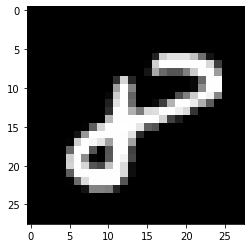

In [ ]:
# This cell calculates min, max, mean, and standard deviation of training set
# It shows first training data

imgs, lbls = next(iter(train_loader))
print(imgs[7].data.shape)
print("min value", imgs.data.min())
print("max value",imgs.data.max())
print("Mean",imgs.data.mean())
print("Std deviation",imgs.data.std())
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [ ]:
# choose the default device.
# It takes GPU if it is available. Otherwise, it takes CPU.
device = get_default_device()

# move the dataloaders and data to the selected device (either GPU or CPU)
# for all training, validation, and test sets.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
# Create model by building an object of MnistModel1 class
model1 = MnistModel1()
to_device(model1, device)

MnistModel1(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(20, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(24, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(26, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv9): Conv2d(28, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv10): Conv2d(30, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=5408, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# print the summary of the model
summary(model1, input_size=(1, 28, 28), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              ReLU-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 12, 28, 28]             876
              ReLU-6           [-1, 12, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           1,744
              ReLU-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 20, 28, 28]           2,900
             ReLU-10           [-1, 20, 28, 28]               0
           Conv2d-11           [-1, 24, 28, 28]           4,344
             ReLU-12           [-1, 24, 28, 28]               0
           Conv2d-13           [-1, 26, 28, 28]           5,642
             ReLU-14           [-1, 26,

In [ ]:
# training the network
history1 = [evaluate(model1, val_loader)]
history1 += fit(epochs, lr, model1, train_loader, val_loader, opt_func)

Epoch [0] - LR [0.001], train_loss: 0.7417, val_loss: 0.1257, val_acc: 0.9635
Epoch [1] - LR [0.001], train_loss: 0.0782, val_loss: 0.0790, val_acc: 0.9787
Epoch [2] - LR [0.001], train_loss: 0.0542, val_loss: 0.0721, val_acc: 0.9791
Epoch [3] - LR [0.001], train_loss: 0.0414, val_loss: 0.0530, val_acc: 0.9835
Epoch [4] - LR [0.001], train_loss: 0.0339, val_loss: 0.0480, val_acc: 0.9862
Epoch [5] - LR [0.001], train_loss: 0.0278, val_loss: 0.0568, val_acc: 0.9852
Epoch [6] - LR [0.001], train_loss: 0.0234, val_loss: 0.0463, val_acc: 0.9875
Epoch [7] - LR [0.001], train_loss: 0.0188, val_loss: 0.0480, val_acc: 0.9883
Epoch [8] - LR [0.001], train_loss: 0.0166, val_loss: 0.0506, val_acc: 0.9879
Epoch [9] - LR [0.001], train_loss: 0.0138, val_loss: 0.0459, val_acc: 0.9881
Epoch [10] - LR [0.001], train_loss: 0.0134, val_loss: 0.0481, val_acc: 0.9862
Epoch [11] - LR [0.001], train_loss: 0.0113, val_loss: 0.0478, val_acc: 0.9881
Epoch [12] - LR [0.001], train_loss: 0.0114, val_loss: 0.0455,

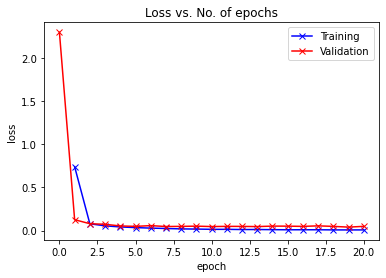

In [ ]:
# plot losses
plot_losses(history1)

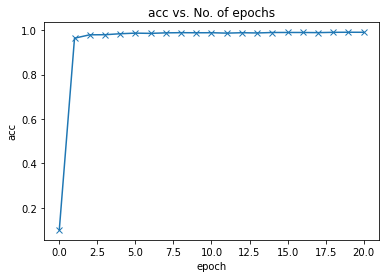

In [ ]:
# plot accuracy
plot_scores(history1)

In [ ]:
# loss and accuracy of last epochs
print(history1[-1])

{'val_loss': 0.048270244151353836, 'val_acc': 0.990039050579071, 'train_loss': 0.0069006336852908134}


Second set of hyper parameters for Part 1 (increasing batch size).

In [ ]:
# Hyper parameters

batch_size = 1024      # number of batch size
val_size = 10000    # size of the validation set
epochs = 20     # number of epochs
lr = 0.001      # learning rate
opt_func = torch.optim.Adam     # optimizer

In [ ]:
# create three tensors for trainin, validation, and test sets

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

# move the dataloaders and data to the selected device (either GPU or CPU)
# for all training, validation, and test sets.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
# training the network
model12 = MnistModel1()
to_device(model12, device)
history12 = [evaluate(model12, val_loader)]
history12 += fit(epochs, lr, model12, train_loader, val_loader, opt_func)

Epoch [0] - LR [0.001], train_loss: 2.3023, val_loss: 2.3023, val_acc: 0.1104
Epoch [1] - LR [0.001], train_loss: 2.3013, val_loss: 2.2997, val_acc: 0.1104
Epoch [2] - LR [0.001], train_loss: 1.2472, val_loss: 0.3010, val_acc: 0.9079
Epoch [3] - LR [0.001], train_loss: 0.2047, val_loss: 0.1650, val_acc: 0.9510
Epoch [4] - LR [0.001], train_loss: 0.1206, val_loss: 0.1217, val_acc: 0.9628
Epoch [5] - LR [0.001], train_loss: 0.0885, val_loss: 0.0899, val_acc: 0.9702
Epoch [6] - LR [0.001], train_loss: 0.0647, val_loss: 0.0715, val_acc: 0.9759
Epoch [7] - LR [0.001], train_loss: 0.0520, val_loss: 0.0631, val_acc: 0.9803
Epoch [8] - LR [0.001], train_loss: 0.0451, val_loss: 0.0607, val_acc: 0.9812
Epoch [9] - LR [0.001], train_loss: 0.0384, val_loss: 0.0579, val_acc: 0.9811
Epoch [10] - LR [0.001], train_loss: 0.0324, val_loss: 0.0575, val_acc: 0.9825
Epoch [11] - LR [0.001], train_loss: 0.0301, val_loss: 0.0577, val_acc: 0.9829
Epoch [12] - LR [0.001], train_loss: 0.0266, val_loss: 0.0601,

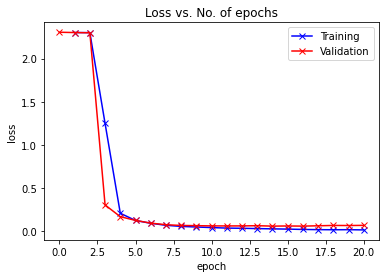

In [ ]:
# plot losses
plot_losses(history12)

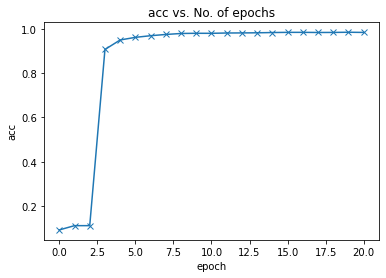

In [ ]:
# plot accuracy
plot_scores(history12)

In [ ]:
# Hyper parameters

batch_size = 128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 20     # number of epochs
lr = 0.001      # learning rate
opt_func = torch.optim.SGD     # optimizer

In [ ]:
# create three tensors for trainin, validation, and test sets

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

# move the dataloaders and data to the selected device (either GPU or CPU)
# for all training, validation, and test sets.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
# training the network
model13 = MnistModel1()
to_device(model13, device)
history13 = [evaluate(model13, val_loader)]
history13 += fit(epochs, lr, model13, train_loader, val_loader, opt_func)

Epoch [0] - LR [0.001], train_loss: 2.3036, val_loss: 2.3036, val_acc: 0.1002
Epoch [1] - LR [0.001], train_loss: 2.3032, val_loss: 2.3033, val_acc: 0.1002
Epoch [2] - LR [0.001], train_loss: 2.3030, val_loss: 2.3031, val_acc: 0.1002
Epoch [3] - LR [0.001], train_loss: 2.3028, val_loss: 2.3030, val_acc: 0.1002
Epoch [4] - LR [0.001], train_loss: 2.3026, val_loss: 2.3028, val_acc: 0.0978
Epoch [5] - LR [0.001], train_loss: 2.3024, val_loss: 2.3027, val_acc: 0.0978
Epoch [6] - LR [0.001], train_loss: 2.3022, val_loss: 2.3026, val_acc: 0.0978
Epoch [7] - LR [0.001], train_loss: 2.3021, val_loss: 2.3025, val_acc: 0.0978
Epoch [8] - LR [0.001], train_loss: 2.3020, val_loss: 2.3024, val_acc: 0.1090
Epoch [9] - LR [0.001], train_loss: 2.3019, val_loss: 2.3023, val_acc: 0.1090
Epoch [10] - LR [0.001], train_loss: 2.3018, val_loss: 2.3023, val_acc: 0.1090
Epoch [11] - LR [0.001], train_loss: 2.3017, val_loss: 2.3022, val_acc: 0.1090
Epoch [12] - LR [0.001], train_loss: 2.3017, val_loss: 2.3021,

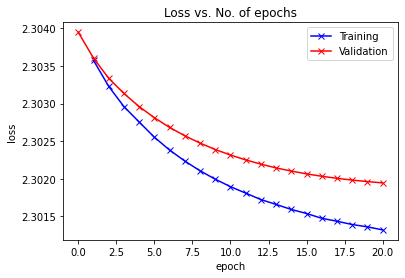

In [ ]:
# plot losses
plot_losses(history13)

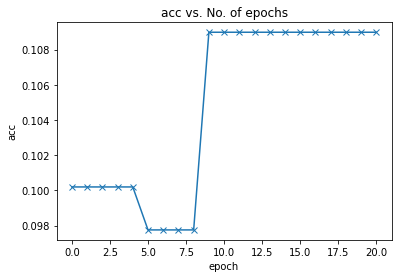

In [ ]:
# plot accuracy
plot_scores(history13)

In [ ]:
# Hyper parameters

batch_size = 128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 20     # number of epochs
lr = 0.01      # learning rate
opt_func = torch.optim.Adam     # optimizer

In [ ]:
# training the network
model14 = MnistModel1()
to_device(model14, device)
history14 = [evaluate(model14, val_loader)]
history14 += fit(epochs, lr, model14, train_loader, val_loader, opt_func)

Epoch [0] - LR [0.01], train_loss: 2.3052, val_loss: 2.3022, val_acc: 0.1090
Epoch [1] - LR [0.01], train_loss: 2.3018, val_loss: 2.3021, val_acc: 0.1090
Epoch [2] - LR [0.01], train_loss: 2.3018, val_loss: 2.3027, val_acc: 0.1090
Epoch [3] - LR [0.01], train_loss: 2.3019, val_loss: 2.3028, val_acc: 0.1090
Epoch [4] - LR [0.01], train_loss: 2.3018, val_loss: 2.3024, val_acc: 0.1034
Epoch [5] - LR [0.01], train_loss: 2.3019, val_loss: 2.3026, val_acc: 0.1090
Epoch [6] - LR [0.01], train_loss: 2.3018, val_loss: 2.3030, val_acc: 0.1090
Epoch [7] - LR [0.01], train_loss: 2.3016, val_loss: 2.3027, val_acc: 0.1090
Epoch [8] - LR [0.01], train_loss: 2.3019, val_loss: 2.3023, val_acc: 0.1090
Epoch [9] - LR [0.01], train_loss: 2.3019, val_loss: 2.3023, val_acc: 0.1090
Epoch [10] - LR [0.01], train_loss: 2.3019, val_loss: 2.3028, val_acc: 0.1090
Epoch [11] - LR [0.01], train_loss: 2.3017, val_loss: 2.3028, val_acc: 0.1090
Epoch [12] - LR [0.01], train_loss: 2.3018, val_loss: 2.3024, val_acc: 0.1

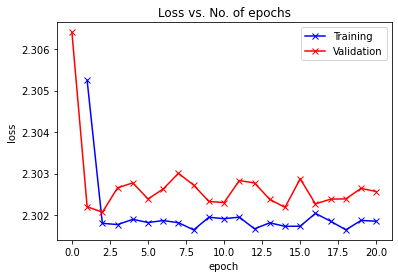

In [ ]:
# plot losses
plot_losses(history14)

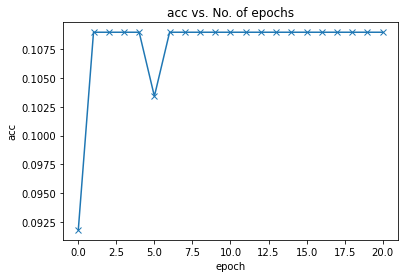

In [ ]:
# plot accuracy
plot_scores(history14)

In [ ]:
# Hyper parameters

batch_size = 128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 20     # number of epochs
lr = 0.0001      # learning rate
opt_func = torch.optim.Adam     # optimizer

In [ ]:
# training the network
model15 = MnistModel1()
to_device(model15, device)
history15 = [evaluate(model15, val_loader)]
history15 += fit(epochs, lr, model15, train_loader, val_loader, opt_func)

Epoch [0] - LR [0.0001], train_loss: 1.9436, val_loss: 0.4500, val_acc: 0.8642
Epoch [1] - LR [0.0001], train_loss: 0.3011, val_loss: 0.2124, val_acc: 0.9356
Epoch [2] - LR [0.0001], train_loss: 0.1726, val_loss: 0.1464, val_acc: 0.9562
Epoch [3] - LR [0.0001], train_loss: 0.1184, val_loss: 0.1111, val_acc: 0.9671
Epoch [4] - LR [0.0001], train_loss: 0.0890, val_loss: 0.0892, val_acc: 0.9741
Epoch [5] - LR [0.0001], train_loss: 0.0738, val_loss: 0.0812, val_acc: 0.9760
Epoch [6] - LR [0.0001], train_loss: 0.0629, val_loss: 0.0698, val_acc: 0.9797
Epoch [7] - LR [0.0001], train_loss: 0.0557, val_loss: 0.0646, val_acc: 0.9812
Epoch [8] - LR [0.0001], train_loss: 0.0473, val_loss: 0.0652, val_acc: 0.9805
Epoch [9] - LR [0.0001], train_loss: 0.0425, val_loss: 0.0590, val_acc: 0.9825
Epoch [10] - LR [0.0001], train_loss: 0.0380, val_loss: 0.0558, val_acc: 0.9840
Epoch [11] - LR [0.0001], train_loss: 0.0347, val_loss: 0.0540, val_acc: 0.9856
Epoch [12] - LR [0.0001], train_loss: 0.0313, val_

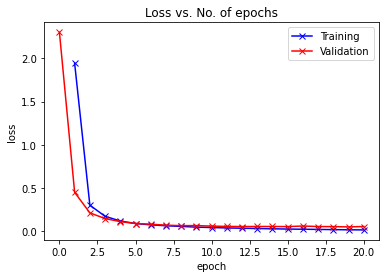

In [ ]:
# plot losses
plot_losses(history15)

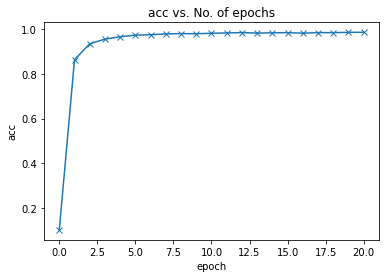

In [ ]:
# plot accuracy
plot_scores(history15)

In [ ]:
# loss and accuracy of last epochs
print("batch:128, Opt:Adam, lr:0.001", history1[-1])
print("batch:1024, Opt:Adam, lr:0.001", history12[-1])
print()
print("batch:128, Opt:Adam, lr:0.001", history1[-1])
print("batch:128, Opt:SGD, lr:0.001", history13[-1])
print()
print("batch:128, Opt:Adam, lr:0.001", history1[-1])
print("batch:128, Opt:Adam, lr:0.01", history14[-1])
print("batch:128, Opt:Adam, lr:0.0001", history15[-1])

batch:128, Opt:Adam, lr:0.001 {'val_loss': 0.048270244151353836, 'val_acc': 0.990039050579071, 'train_loss': 0.0069006336852908134}
batch:1024, Opt:Adam, lr:0.001 {'val_loss': 0.06419938057661057, 'val_acc': 0.9851381182670593, 'train_loss': 0.01122220791876316}

batch:128, Opt:Adam, lr:0.001 {'val_loss': 0.048270244151353836, 'val_acc': 0.990039050579071, 'train_loss': 0.0069006336852908134}
batch:128, Opt:SGD, lr:0.001 {'val_loss': 2.3019444942474365, 'val_acc': 0.10898437350988388, 'train_loss': 2.301318645477295}

batch:128, Opt:Adam, lr:0.001 {'val_loss': 0.048270244151353836, 'val_acc': 0.990039050579071, 'train_loss': 0.0069006336852908134}
batch:128, Opt:Adam, lr:0.01 {'val_loss': 2.302565336227417, 'val_acc': 0.10898437350988388, 'train_loss': 2.3018505573272705}
batch:128, Opt:Adam, lr:0.0001 {'val_loss': 0.054381515830755234, 'val_acc': 0.9872070550918579, 'train_loss': 0.015052048489451408}


The best accuracy on the validation set that I got is 0.99 on batch size: 128, optimizer: Adam, and learning rate: 0.001.
Increasing batch size from 1028 to 1024 deacreased the accuracy a little. Changing Adam optimizer to stochastic gradient descent changed the acurracy dramatically. Increasing the learning rate from 0.001 to 0.01 also decreased the accuracy dramatilcally. Reducing the learning rate from 0.001 to 0.0001 decrease the accuracy a little since I kept the epoch size same. With more epochs 0.0001 should give better accuracy than 0.001 learning rate. To have better comparison we must train the model on broader range of hyperparameters. Since running the model takes long time and free google colab restricts resource usage, I run the model only on 4 set of hyper parameters.

**Part 2.** An inverted CNN where the number of filters in each layer decreases as the depth of the network grows i.e., the L th layer will have less filters than the (L-1) th layer.

In [ ]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 20     # number of epochs
lr = 0.001      # learning rate
opt_func = torch.optim.Adam     # optimizer

In [ ]:
# This class inheritance from "MnistModelBase" class.
# Layers of the CNN is defined here.

class MnistModel2(MnistModelBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding='same')  # chnl-in, out, krnl
        self.conv2 = torch.nn.Conv2d(32, 30, 3, padding='same')
        self.conv3 = torch.nn.Conv2d(30, 28, 3, padding='same')
        self.conv4 = torch.nn.Conv2d(28, 26, 3, padding='same')
        self.conv5 = torch.nn.Conv2d(26, 24, 3, padding='same')
        self.conv6 = torch.nn.Conv2d(24, 20, 3, padding='same')
        self.conv7 = torch.nn.Conv2d(20, 16, 3, padding='same')
        self.conv8 = torch.nn.Conv2d(16, 12, 3, padding='same')
        self.conv9 = torch.nn.Conv2d(12, 8, 3, padding='same')
        self.conv10 = torch.nn.Conv2d(8, 4, 3, padding='same')
        self.pool = torch.nn.MaxPool2d(2, 2)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(784, 100)
        self.fc2 = torch.nn.Linear(100, 10)  # 10 classes

    def forward(self, xb):

        # CNN
        x = self.relu(self.conv1(xb))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.pool(x)

        # MLP
        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# Model (on GPU)
model2 = MnistModel2()
to_device(model2, device)

MnistModel2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(32, 30, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(30, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(28, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(26, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(24, 20, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(20, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(16, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv9): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv10): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# print the summary of the model
summary(model2, input_size=(1, 28, 28), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 30, 28, 28]           8,670
              ReLU-4           [-1, 30, 28, 28]               0
            Conv2d-5           [-1, 28, 28, 28]           7,588
              ReLU-6           [-1, 28, 28, 28]               0
            Conv2d-7           [-1, 26, 28, 28]           6,578
              ReLU-8           [-1, 26, 28, 28]               0
            Conv2d-9           [-1, 24, 28, 28]           5,640
             ReLU-10           [-1, 24, 28, 28]               0
           Conv2d-11           [-1, 20, 28, 28]           4,340
             ReLU-12           [-1, 20, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           2,896
             ReLU-14           [-1, 16,

In [ ]:
# training the network

history2 = [evaluate(model2, val_loader)]
history2 += fit(epochs, lr, model2, train_loader, val_loader, opt_func)

Epoch [0] - LR [0.001], train_loss: 0.4154, val_loss: 0.1030, val_acc: 0.9686
Epoch [1] - LR [0.001], train_loss: 0.0787, val_loss: 0.0715, val_acc: 0.9774
Epoch [2] - LR [0.001], train_loss: 0.0581, val_loss: 0.0602, val_acc: 0.9819
Epoch [3] - LR [0.001], train_loss: 0.0477, val_loss: 0.0592, val_acc: 0.9824
Epoch [4] - LR [0.001], train_loss: 0.0389, val_loss: 0.0588, val_acc: 0.9815
Epoch [5] - LR [0.001], train_loss: 0.0342, val_loss: 0.0542, val_acc: 0.9854
Epoch [6] - LR [0.001], train_loss: 0.0327, val_loss: 0.0639, val_acc: 0.9821
Epoch [7] - LR [0.001], train_loss: 0.0276, val_loss: 0.0618, val_acc: 0.9842
Epoch [8] - LR [0.001], train_loss: 0.0256, val_loss: 0.0429, val_acc: 0.9862
Epoch [9] - LR [0.001], train_loss: 0.0221, val_loss: 0.0458, val_acc: 0.9877
Epoch [10] - LR [0.001], train_loss: 0.0216, val_loss: 0.0492, val_acc: 0.9871
Epoch [11] - LR [0.001], train_loss: 0.0177, val_loss: 0.0516, val_acc: 0.9859
Epoch [12] - LR [0.001], train_loss: 0.0166, val_loss: 0.0565,

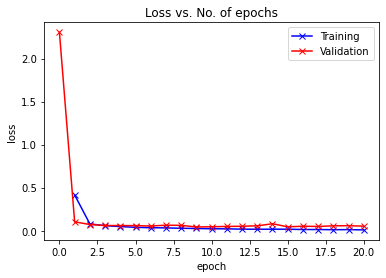

In [ ]:
plot_losses(history2)

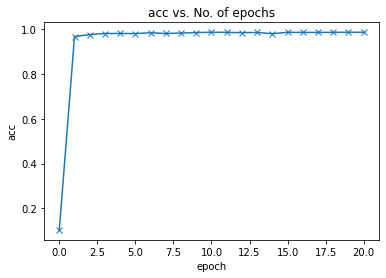

In [ ]:
plot_scores(history2)

In [ ]:
# loss and accuracy of last epochs
print("increasing filters", history1[-1])
print("decreasing filters", history2[-1])

increasing filters {'val_loss': 0.048270244151353836, 'val_acc': 0.990039050579071, 'train_loss': 0.0069006336852908134}
decreasing filters {'val_loss': 0.05261586979031563, 'val_acc': 0.987500011920929, 'train_loss': 0.008855897933244705}


The result shows that the accuracy on the validation set is higher for the increasing filters case than for the decreasing filters case. To have more reliable conclusion about comparing increasing with decreasing number of filters, we must run the model for broad range of hyperparameters.

**Part 3.** An hour-glass shaped CNN where the number of filters will increase till the L th layer and reduce afterwards.

In [ ]:
# Hyper parameters

batch_size=128      # number of batch size
val_size = 10000    # size of the validation set
epochs = 20     # number of epochs
lr = 0.001      # learning rate
opt_func = torch.optim.Adam     # optimizer

In [ ]:
# This class inheritance from "MnistModelBase" class.
# Layers of the CNN is defined here.

class MnistModel3(MnistModelBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(1, 4, 3, padding='same')  # chnl-in, out, krnl
        self.conv2 = torch.nn.Conv2d(4, 8, 3, padding='same')
        self.conv3 = torch.nn.Conv2d(8, 16, 3, padding='same')
        self.conv4 = torch.nn.Conv2d(16, 32, 3, padding='same')
        self.conv5 = torch.nn.Conv2d(32, 64, 3, padding='same')

        self.conv6 = torch.nn.Conv2d(64, 32, 3, padding='same')
        self.conv7 = torch.nn.Conv2d(32, 16, 3, padding='same')
        self.conv8 = torch.nn.Conv2d(16, 8, 3, padding='same')
        self.conv9 = torch.nn.Conv2d(8, 4, 3, padding='same')
        self.conv10 = torch.nn.Conv2d(4, 1, 3)

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(169, 100)
        self.fc2 = torch.nn.Linear(100, 10)  # 10 classes

    def forward(self, xb):

        # CNN
        x = self.relu(self.conv1(xb))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.relu(self.conv7(x))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.relu(self.conv10(x))
        x = self.pool(x)

        # MLP
        x = x.view(x.shape[0], -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
# Model (on GPU)
model3 = MnistModel3()
to_device(model3, device)

MnistModel3(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv7): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv8): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv9): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv10): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=169, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# print the summary of the model
summary(model3, input_size=(1, 28, 28), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              ReLU-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
              ReLU-4            [-1, 8, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,168
              ReLU-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 32, 28, 28]           4,640
              ReLU-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          18,496
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11           [-1, 32, 28, 28]          18,464
             ReLU-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           4,624
             ReLU-14           [-1, 16,

In [ ]:
# traing the model for the third part
history3 = [evaluate(model3, val_loader)]
history3 += fit(epochs, lr, model3, train_loader, val_loader, opt_func)

Epoch [0] - LR [0.001], train_loss: 0.4662, val_loss: 0.1704, val_acc: 0.9501
Epoch [1] - LR [0.001], train_loss: 0.1312, val_loss: 0.1125, val_acc: 0.9664
Epoch [2] - LR [0.001], train_loss: 0.0923, val_loss: 0.0984, val_acc: 0.9718
Epoch [3] - LR [0.001], train_loss: 0.0739, val_loss: 0.0761, val_acc: 0.9759
Epoch [4] - LR [0.001], train_loss: 0.0635, val_loss: 0.0729, val_acc: 0.9787
Epoch [5] - LR [0.001], train_loss: 0.0562, val_loss: 0.0652, val_acc: 0.9800
Epoch [6] - LR [0.001], train_loss: 0.0490, val_loss: 0.0670, val_acc: 0.9810
Epoch [7] - LR [0.001], train_loss: 0.0438, val_loss: 0.0601, val_acc: 0.9822
Epoch [8] - LR [0.001], train_loss: 0.0385, val_loss: 0.0569, val_acc: 0.9851
Epoch [9] - LR [0.001], train_loss: 0.0362, val_loss: 0.0696, val_acc: 0.9812
Epoch [10] - LR [0.001], train_loss: 0.0337, val_loss: 0.0546, val_acc: 0.9855
Epoch [11] - LR [0.001], train_loss: 0.0306, val_loss: 0.0652, val_acc: 0.9832
Epoch [12] - LR [0.001], train_loss: 0.0300, val_loss: 0.0577,

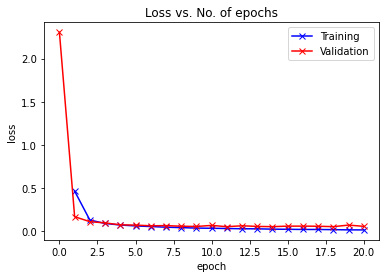

In [ ]:
plot_losses(history3)

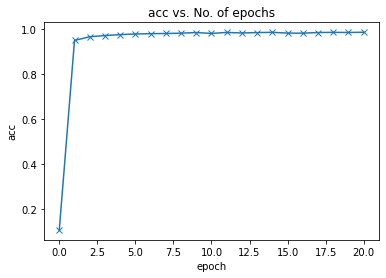

In [ ]:
plot_scores(history3)

In [ ]:
print("increasing filters", history1[-1])
print("decreasing filters", history2[-1])
print("increasing and decreasing filters", history3[-1])

increasing filters {'val_loss': 0.048270244151353836, 'val_acc': 0.990039050579071, 'train_loss': 0.0069006336852908134}
decreasing filters {'val_loss': 0.05261586979031563, 'val_acc': 0.987500011920929, 'train_loss': 0.008855897933244705}
increasing and decreasing filters {'val_loss': 0.058704983443021774, 'val_acc': 0.9864257574081421, 'train_loss': 0.01725153811275959}


The results show that the accuracy on the validation set is the highest for the increasing filters and the lowest for the incerasing and decreasing filters. The decreasing filters case is at the second place. Again, to have more reliable conclusion, one must run the models on broad range of hyperparameters.